In [1]:
from filter import *
import librosa
import librosa.display
import IPython.display as ipd

plt.rcParams['figure.figsize'] = [40, 25]

In [2]:
N = 100000
f = 220
r = 0.99999

In [3]:
noise = np.zeros(N, dtype = 'complex')
for i in range(N):
    noise[i] = (2 * (random() - 0.5) + 2 * (random() - 0.5) * 1j)
            # = 2 * (random() - 0.5) * Fresult[i - 1] * 1j / np.abs(Fresult[i - 1]) ** 2 # proportional noise

In [4]:
# for i in range(N):
#     if random() > 0.001:
#         noise[i] = 0

In [5]:
F = onepole(r, f)
F.forget()
Fresult = np.zeros(N, dtype = 'complex')
Fresult[-1] = 1
Reference = np.array([np.exp(i * ftoa(f) * 1j) for i in range(N)])
for i in range(N):
    Fresult[i] = F(noise[i])
    F.tick()


Presult = Fresult / Reference

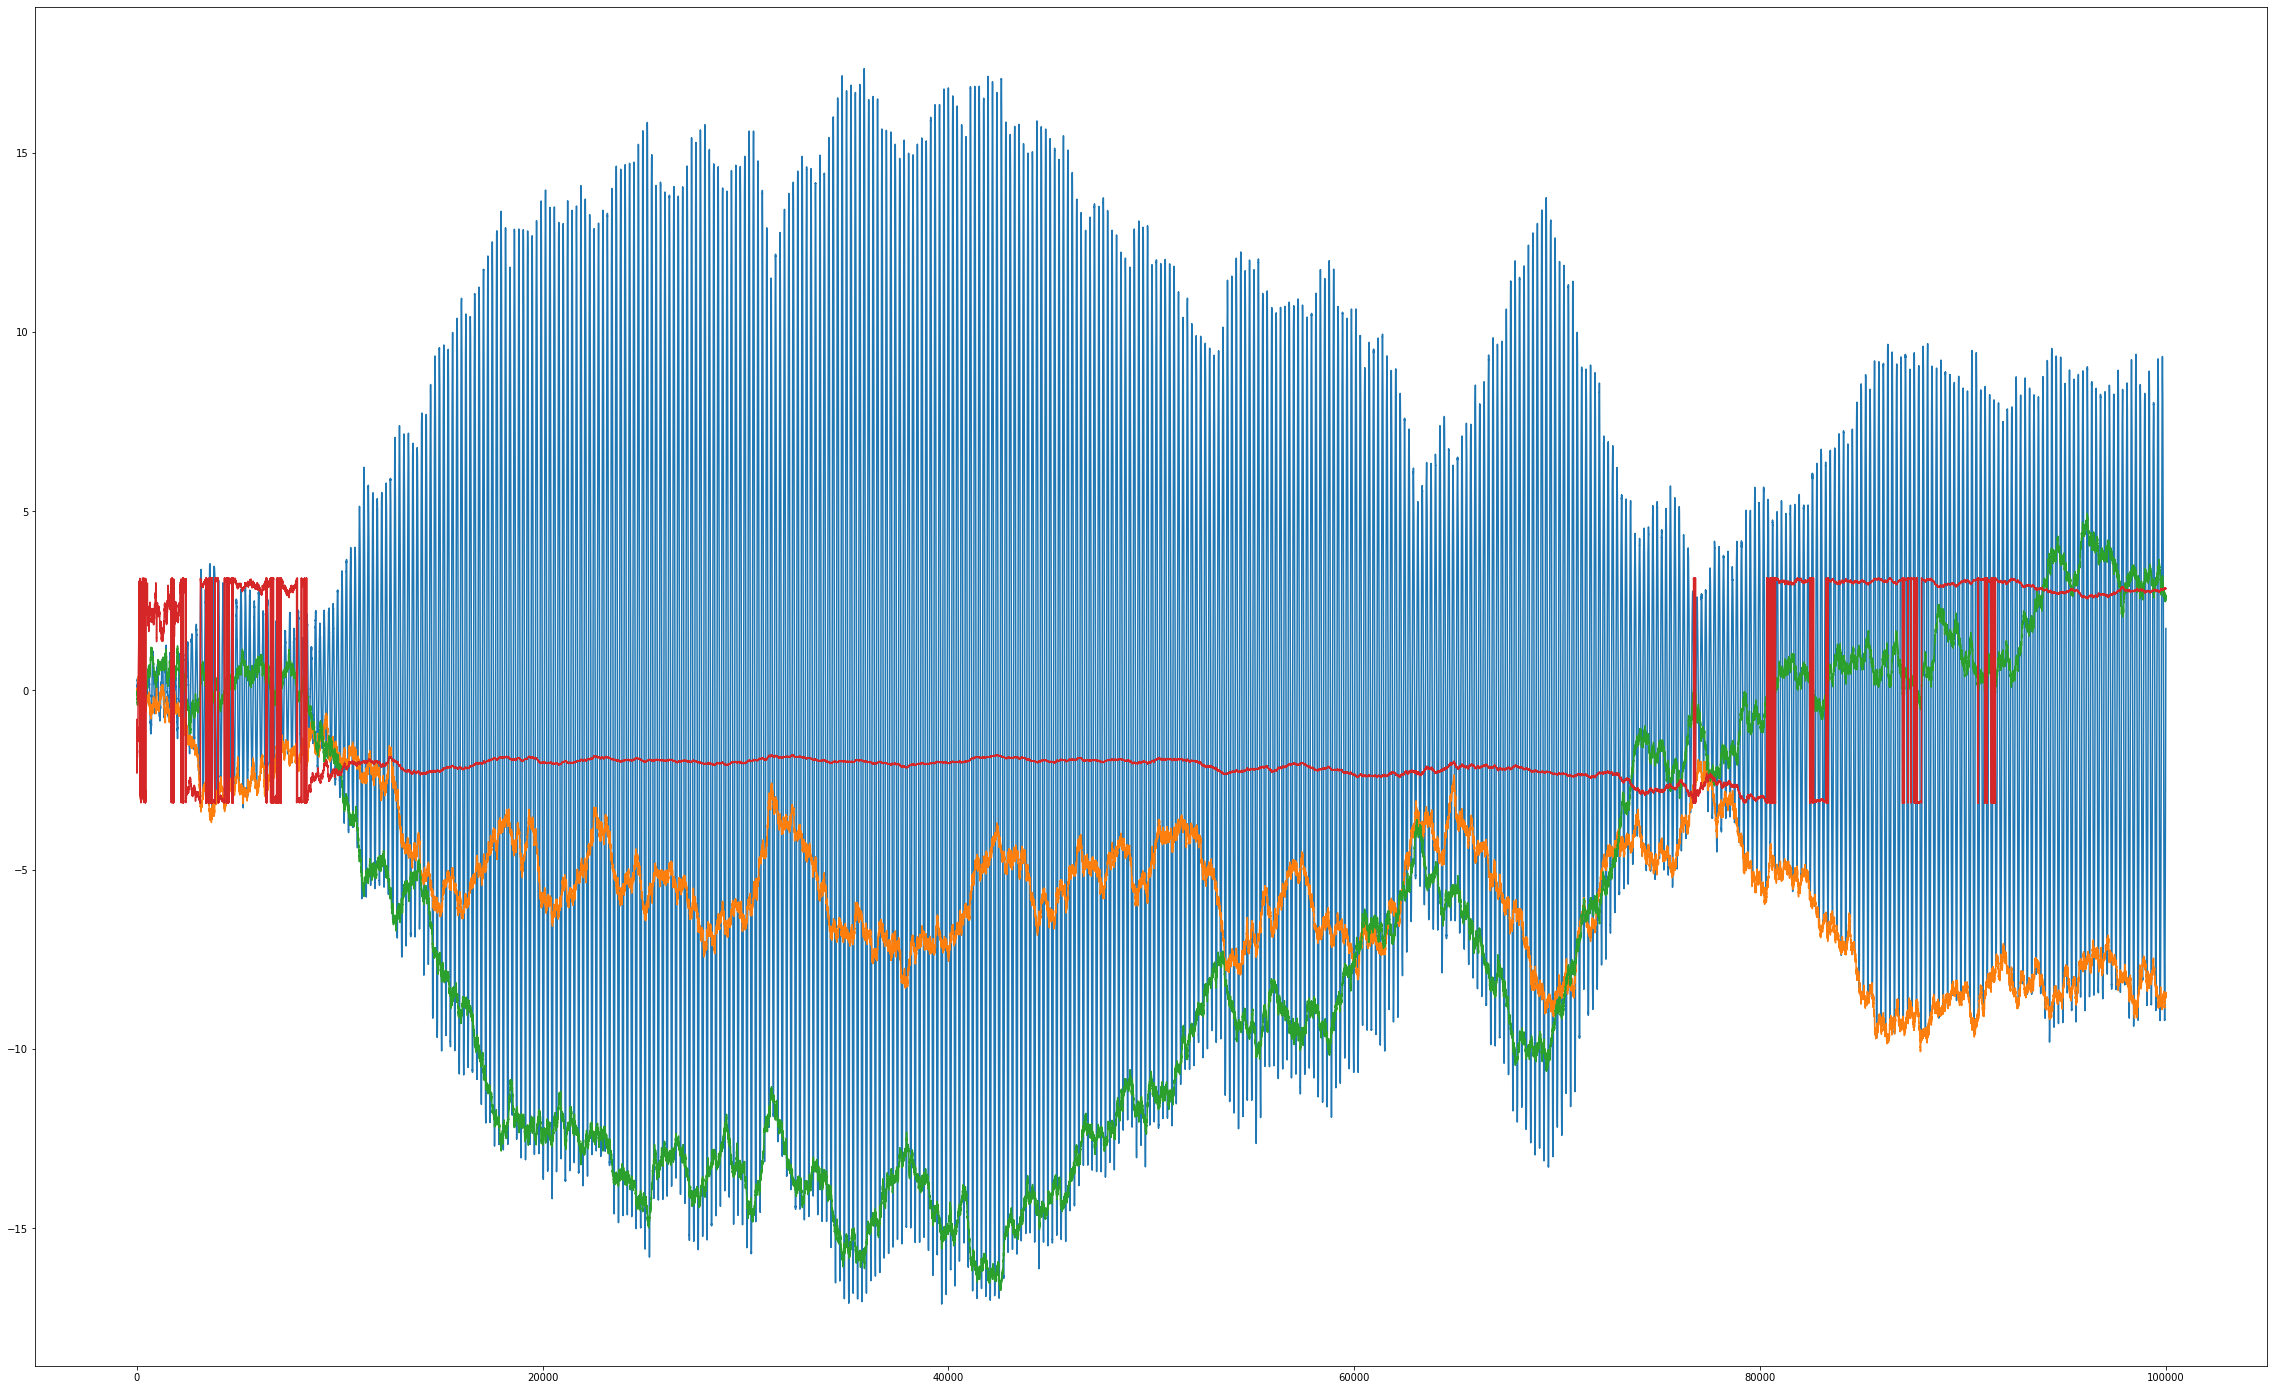

In [7]:
k = N
# plt.plot(np.real(noise[:k]))
plt.plot(np.real(Fresult[:k]))
# plt.plot(np.imag(Fresult[:k])); 
plt.plot(np.real(Presult[:k]))
plt.plot(np.imag(Presult[:k]))
plt.plot(np.angle(Presult[:k]));
plt.show()

The idea is to run $m$ resonant one-pole (bandpass) filters in parallel, each with an update rule:
$$ F_j[n] = x[n] + r_j e^{i f_j} F_j[n-1] + \sum_{\ell \neq j} k_{\ell j} (F_l[n-1] - F_j[n-1]). $$

The coupling constants $\{k_{\ell j}$ determine how much bleed we have between filters. For this not to work as desired, we should probably set $k_{\ell j} \simeq (f_j - f_l)^{-2}$, which is to say, make sure that filters whose frequencies are far apart have little effect on each other. 

In [8]:
N = 1000000
noise = np.zeros(N, dtype = 'complex')
for i in range(N):
    noise[i] = (2 * (random() - 0.5) + 2 * (random() - 0.5) * 1j)
            # = 2 * (random() - 0.5) * Fresult[i - 1] * 1j / np.abs(Fresult[i - 1]) ** 2 # proportional noise

In [9]:
# for i in range(N):
#     if random() > 0.01:
#         noise[i] = 0

In [38]:
pitches = [43, 52, 53, 60]
overtones = 7
m = overtones * len(pitches)
frequencies = np.array([mtof(p) * (1 + i) for p in pitches for i in range(overtones)])
angles = np.array([ftoa(f) for f in frequencies])

In [39]:
tick = np.exp(angles * 1j) # np.array([np.exp(ftoa(f) * 1j) for f in frequencies])
references = np.zeros((N, m), dtype = 'complex')
references[0] = 1
for i in range(1, N):
    references[i] = references[i - 1] * tick
# references = np.array([[np.exp(i * ftoa(f) * 1j) for f in frequencies] for i in range(N)]) # takes strangely long

In [76]:
sum(sum(coupling) ** 2)

-34.86252764922013j

In [74]:
r = 0.999999999

f = lambda x : x ** 2

coupling = np.zeros((m, m), dtype = 'complex')
weight = np.zeros(m)
for i in range(m):
    weight[i] = sum([1 / f(frequencies[i] - frequencies[j]) for j in range(m) if i != j])
    
# k = 0.0000001
k = 0.001
for i in range(m):
    for j in range(m):
        coupling[i,j] = weight[i] if i == j else -1j / f(frequencies[i] - frequencies[j])

F = np.zeros(m, dtype = 'complex')
filter_out = np.zeros((m, N), dtype = 'complex')
phase_out = np.zeros((m, N), dtype = 'complex')

for i in range(N):
    x = noise[i]
    filter_out[:,i] = F[:]
    phase_out[:,i] = F / references[i]
    F = x + r * np.exp(1j * angles) * F + k * coupling @ F
    


KeyboardInterrupt: 

In [61]:
seconds = 10
rate = 48000
k = int(rate * seconds)
audio = np.sum(np.real(filter_out), axis = 0)[:k]
print(max(audio))
audio /= max(audio)

1.7786416742286455e+306


/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


/var/folders/cn/29rmrlyj0t3f_553h8vgm0000000gn/T/ipykernel_65210/3547614443.py:3: RuntimeWarning: overflow encountered in absolute
  spacing = 2 * np.max(np.abs(filter_out[:,:k]))


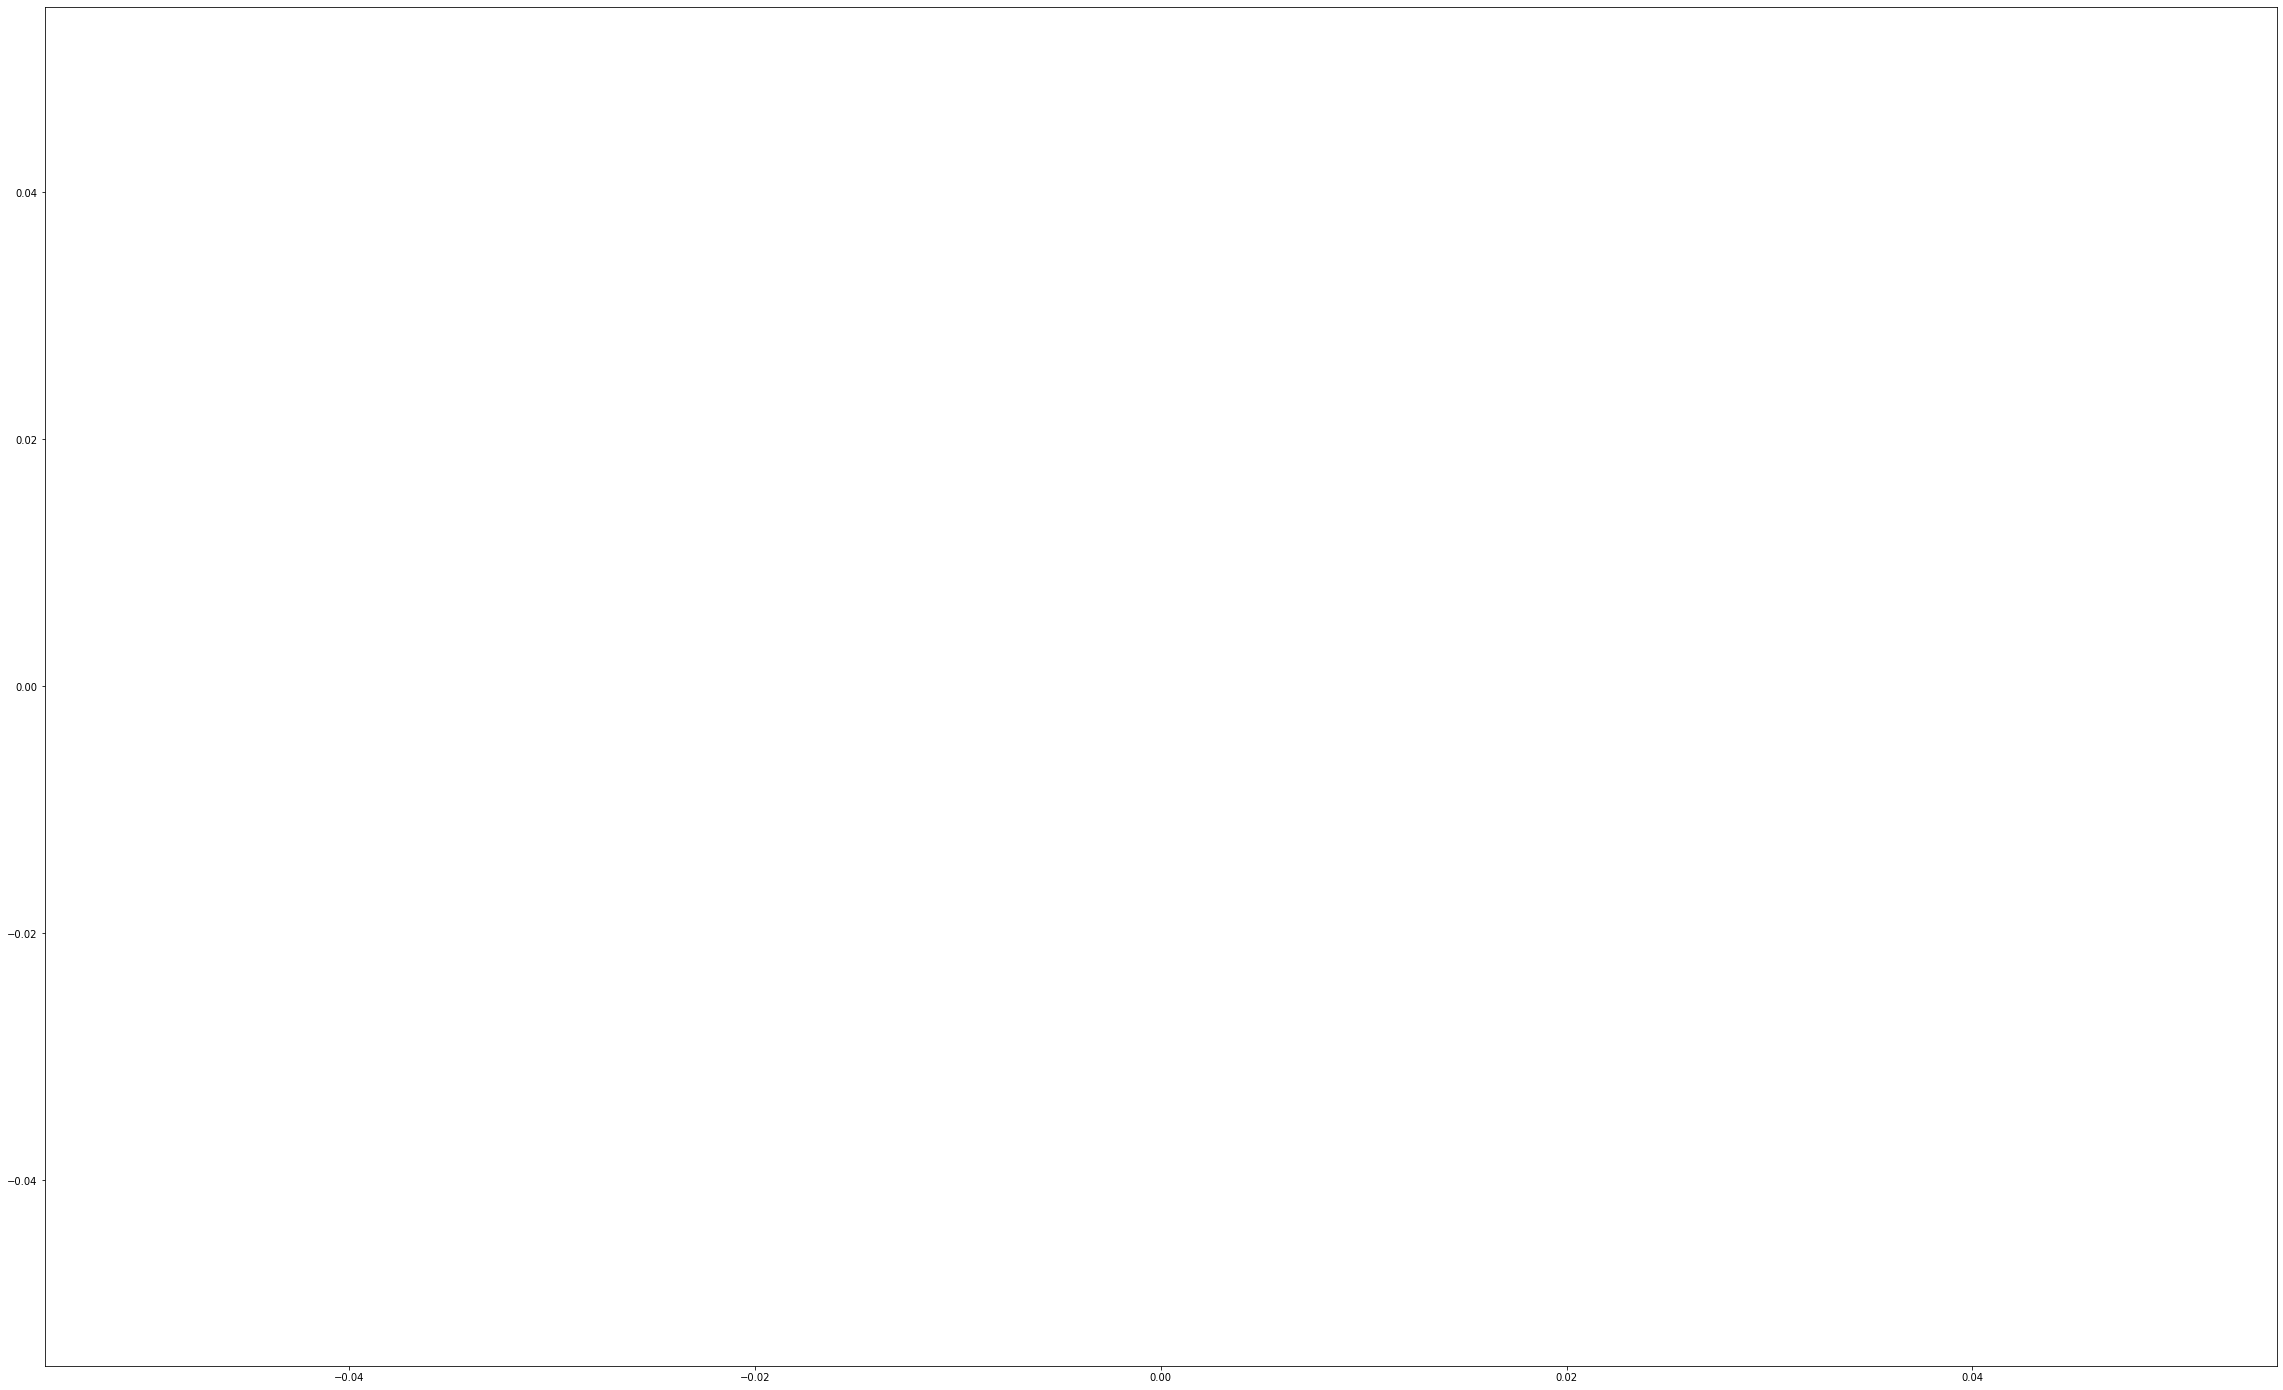

In [59]:
byfreq = sorted([(f, i) for i, f in enumerate(frequencies)])
permutation = np.array([a for f, a in byfreq])
spacing = 2 * np.max(np.abs(filter_out[:,:k]))
for i in range(m):
    plt.plot(spacing * i + np.real(filter_out[permutation[i]][:k]))
    plt.plot(spacing * i + spacing / 2 * np.sin(np.angle(phase_out[permutation[i]][:k])))

plt.show()

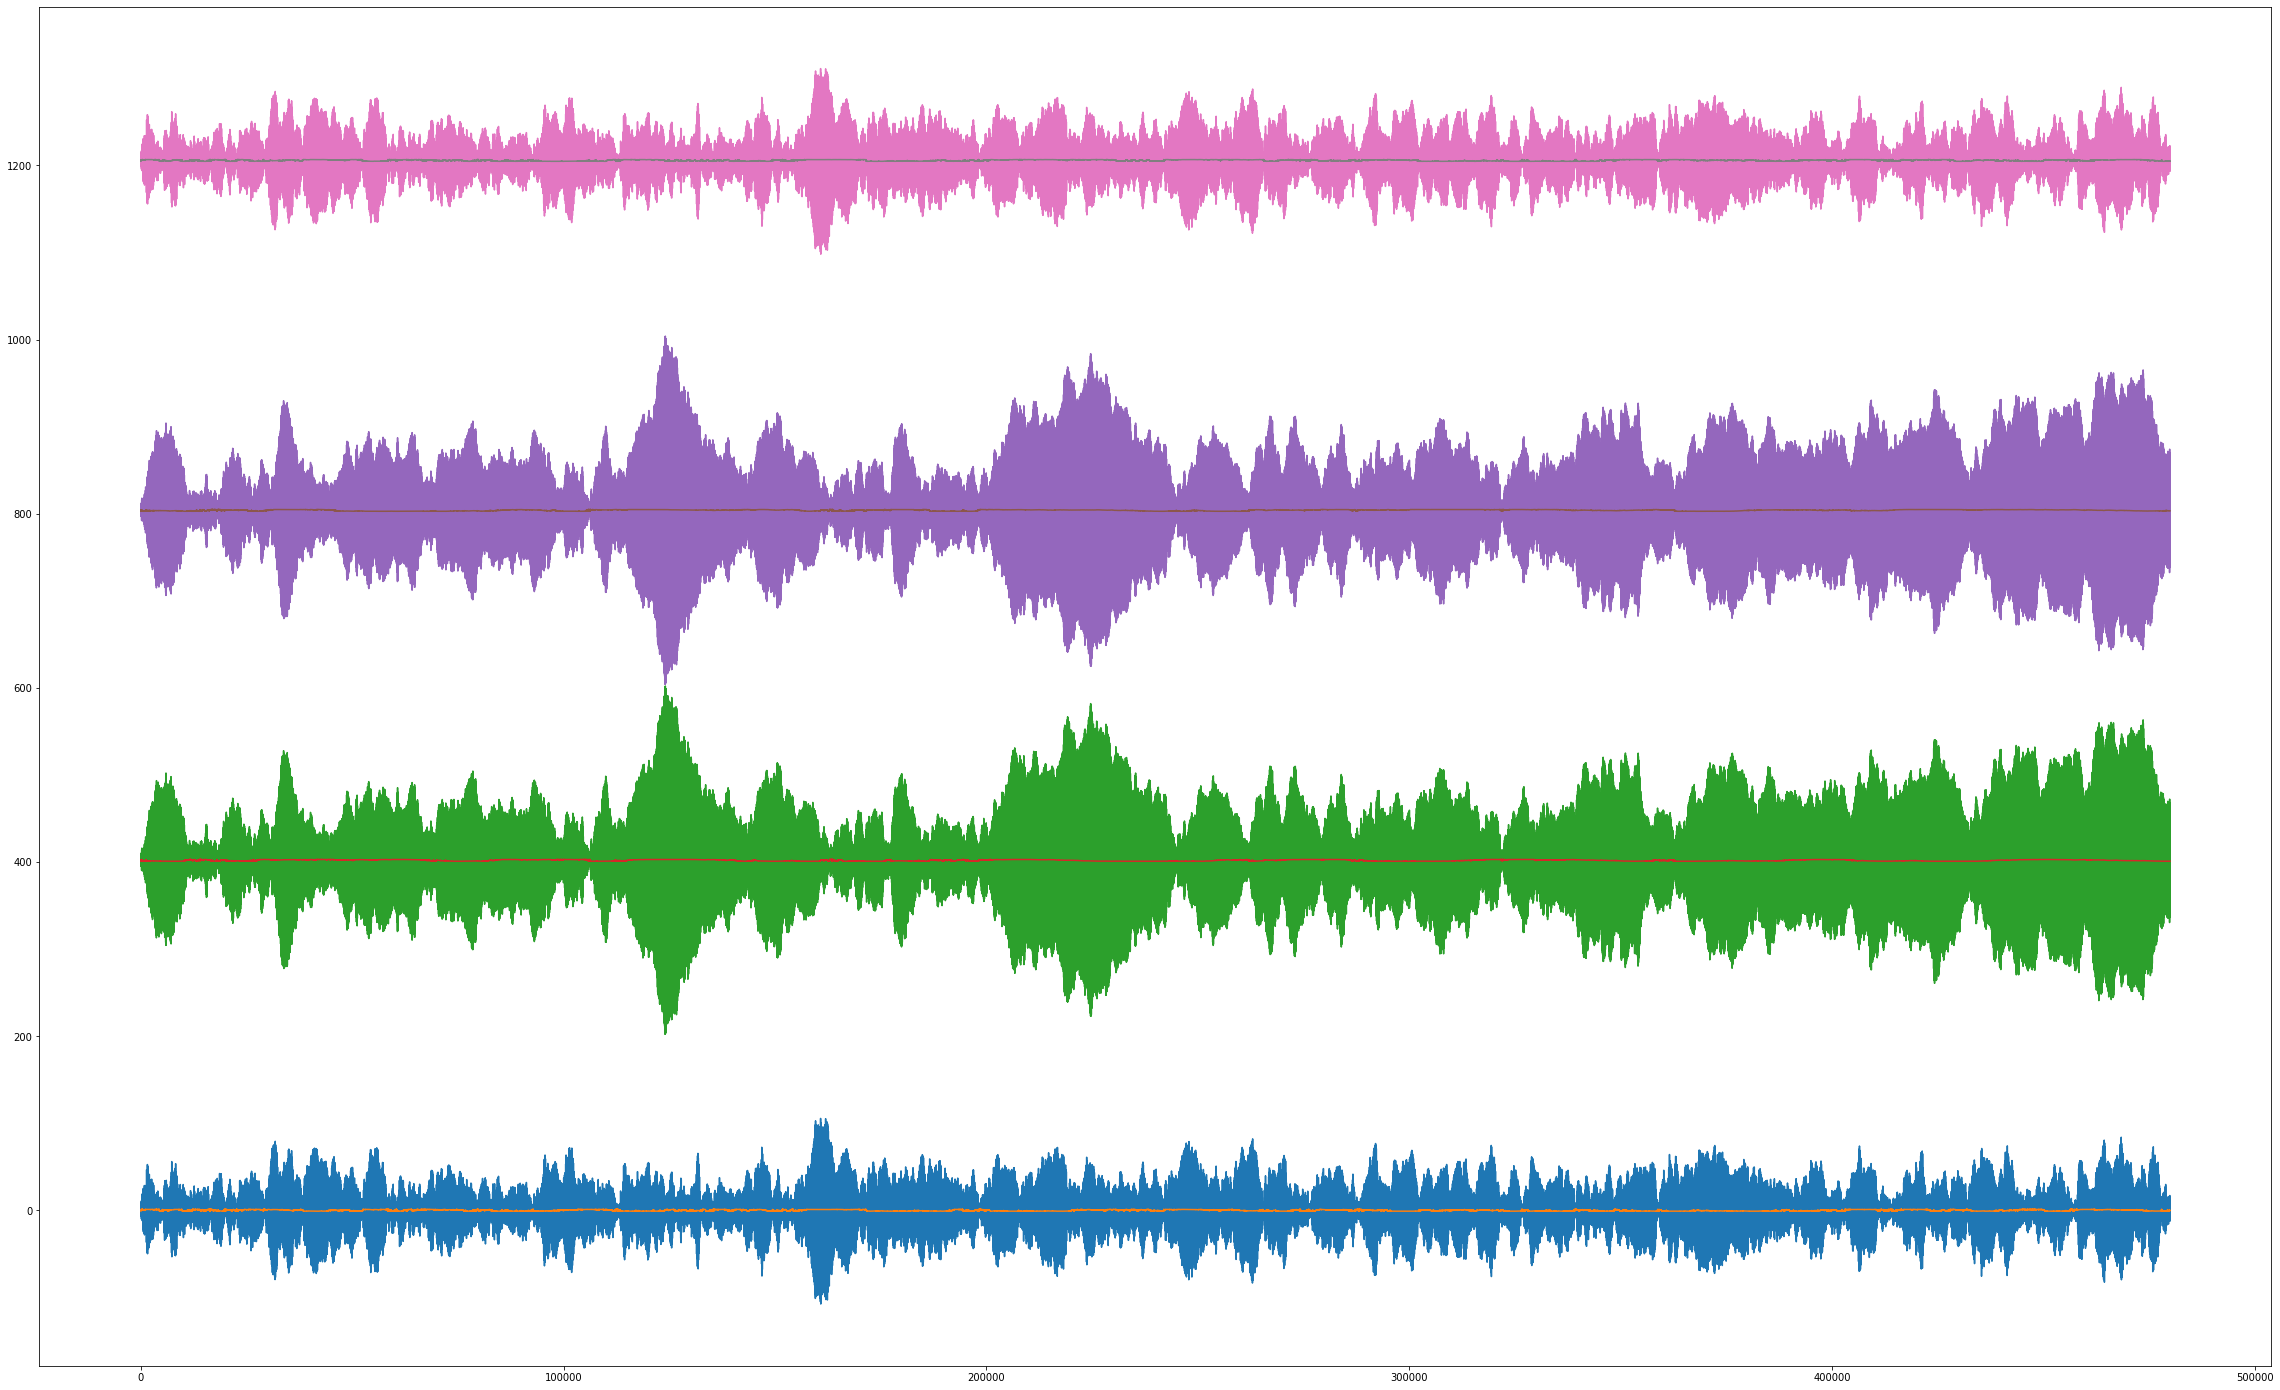

In [55]:
seconds = 10
rate = 48000
k = rate * seconds

byfreq = sorted([(f, i) for i, f in enumerate(frequencies)])
permutation = np.array([a for f, a in byfreq])
spacing = 2 * np.max(np.abs(filter_out[:,:k]))
oldf = (0,0)
close = []
for i in range(m):
    if byfreq[i][0] - oldf[0] < 2:
        close += [oldf[1], byfreq[i][1]]
        
    oldf = byfreq[i]

close = list(set(close))
spacing = 2 * np.max(np.abs(filter_out[close,:k]))
for i, index in enumerate(close):
    plt.plot(spacing * i + np.real(filter_out[index][:k]))
    plt.plot(spacing * i + np.sin(np.angle(phase_out[index][:k])))

plt.show()
interferences = np.sum(np.real(filter_out)[close], axis = 0)[:k]

In [56]:
ipd.Audio(audio, rate = rate)

In [45]:
ipd.Audio(interferences, rate = rate)

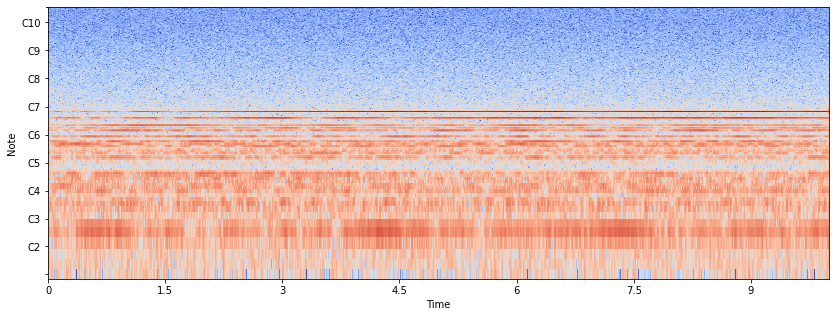

In [46]:
X = librosa.stft(audio)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=rate, x_axis='time', y_axis='fft_note')

In [47]:
byfreq[11]

(523.2511306011972, 22)

In [48]:
F = Filter([2,1],[1,2])

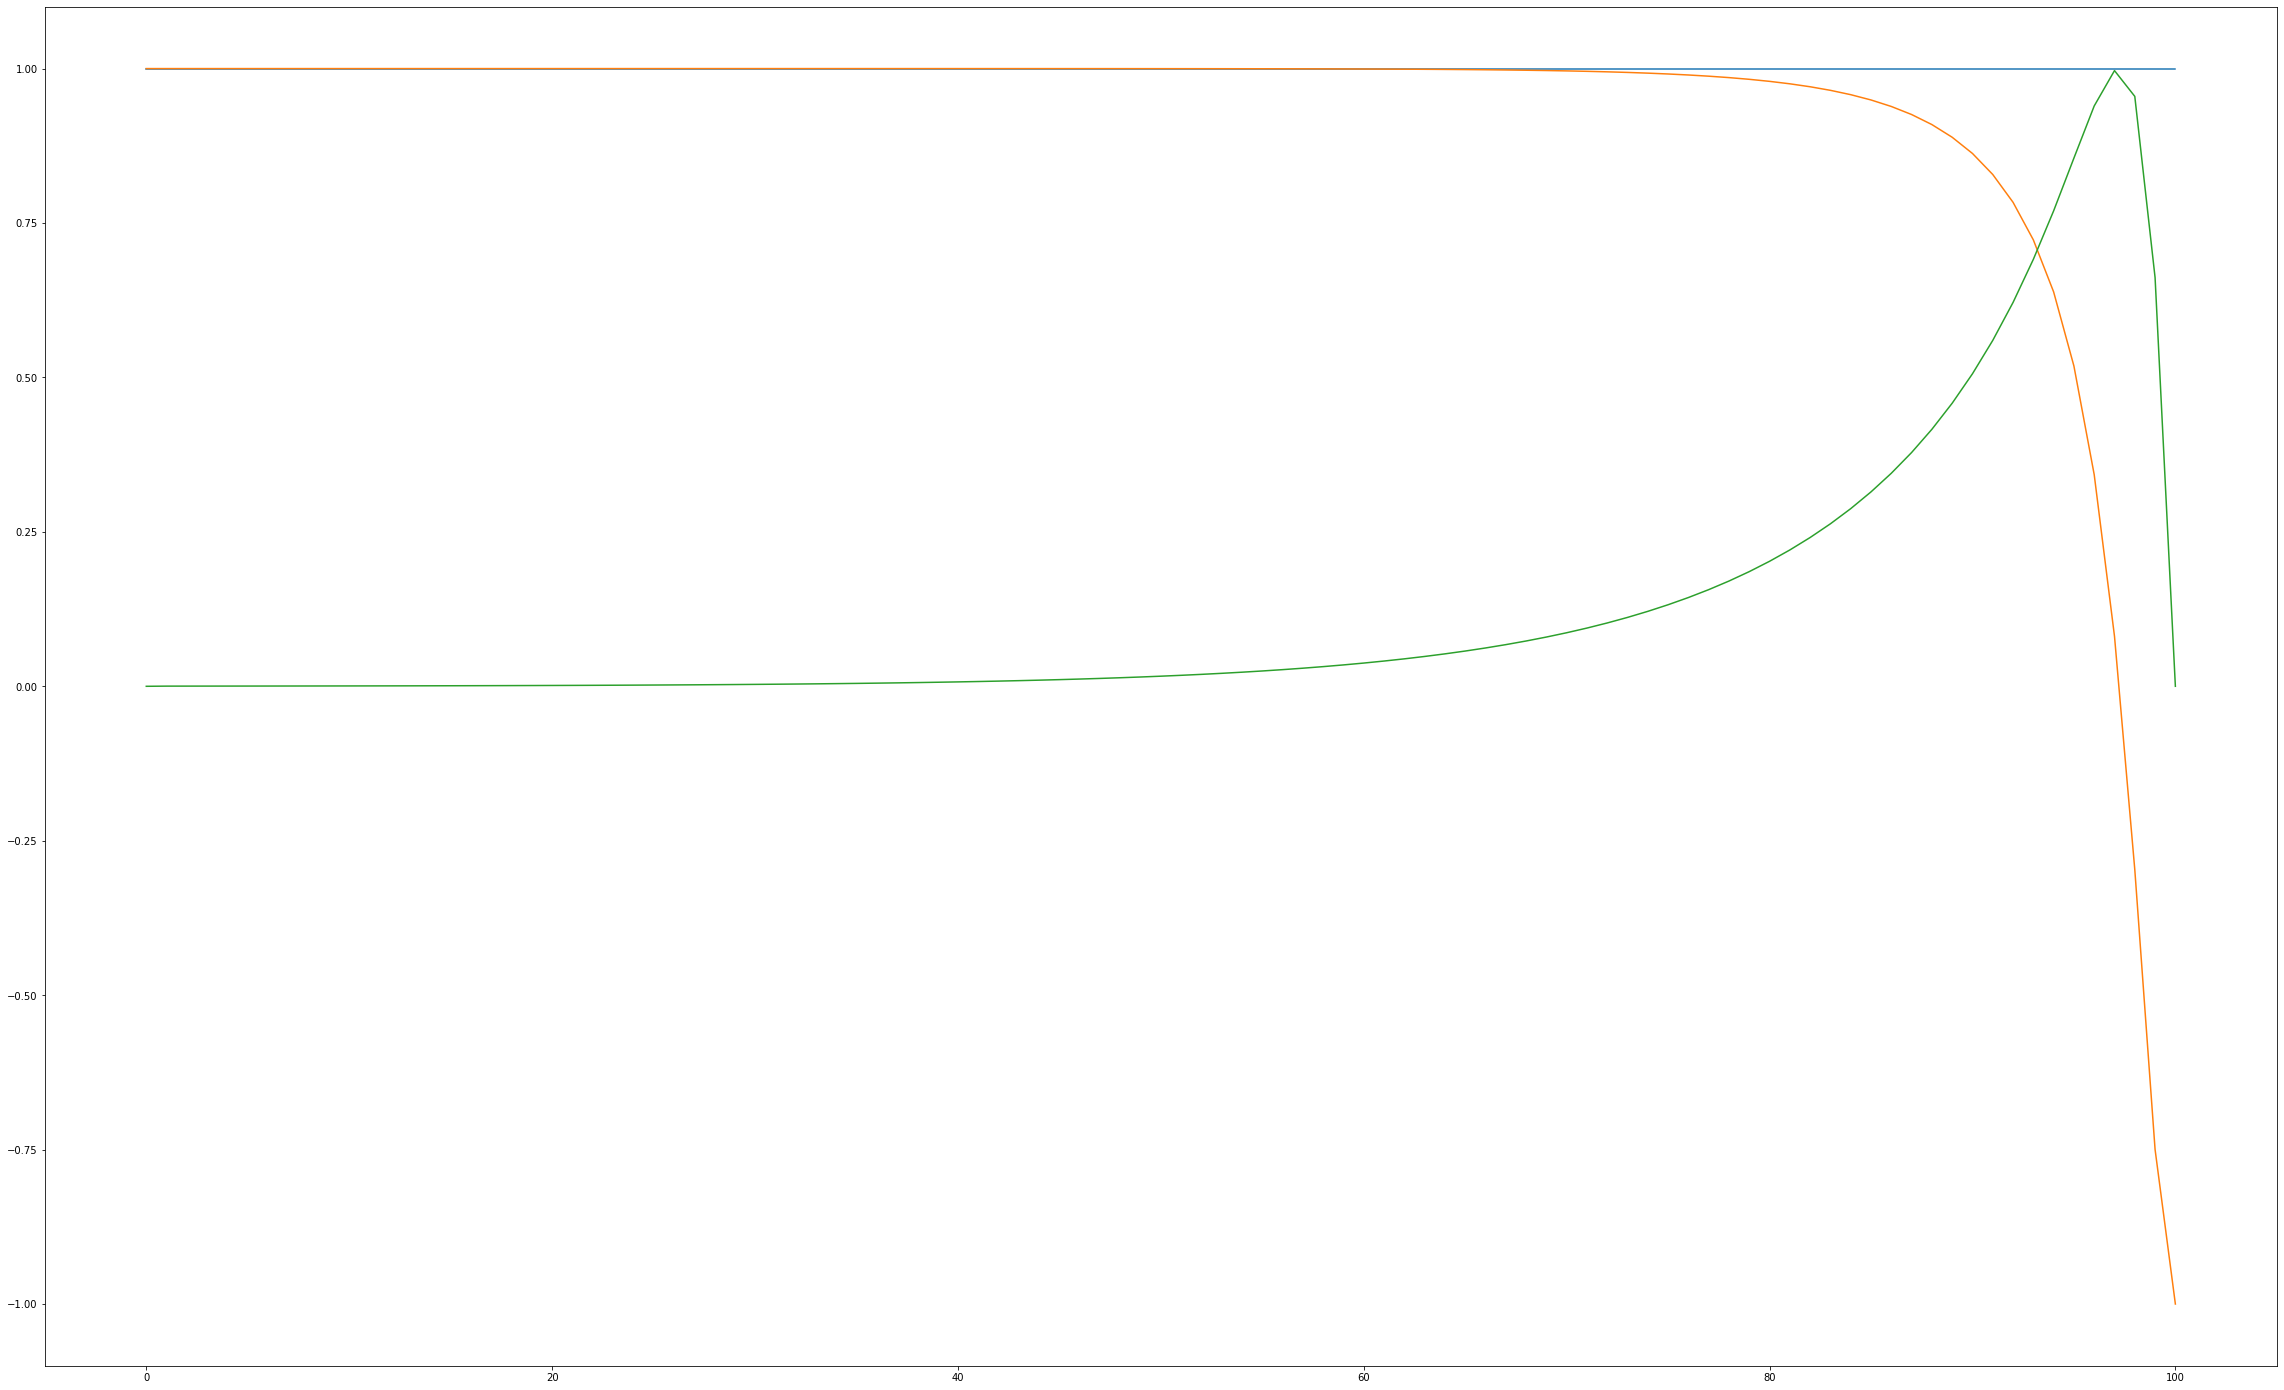

In [49]:
F.eq(100)

In [50]:
def schwarz(alpha):
    return Filter([alpha,-1],[1,-np.conj(alpha)])

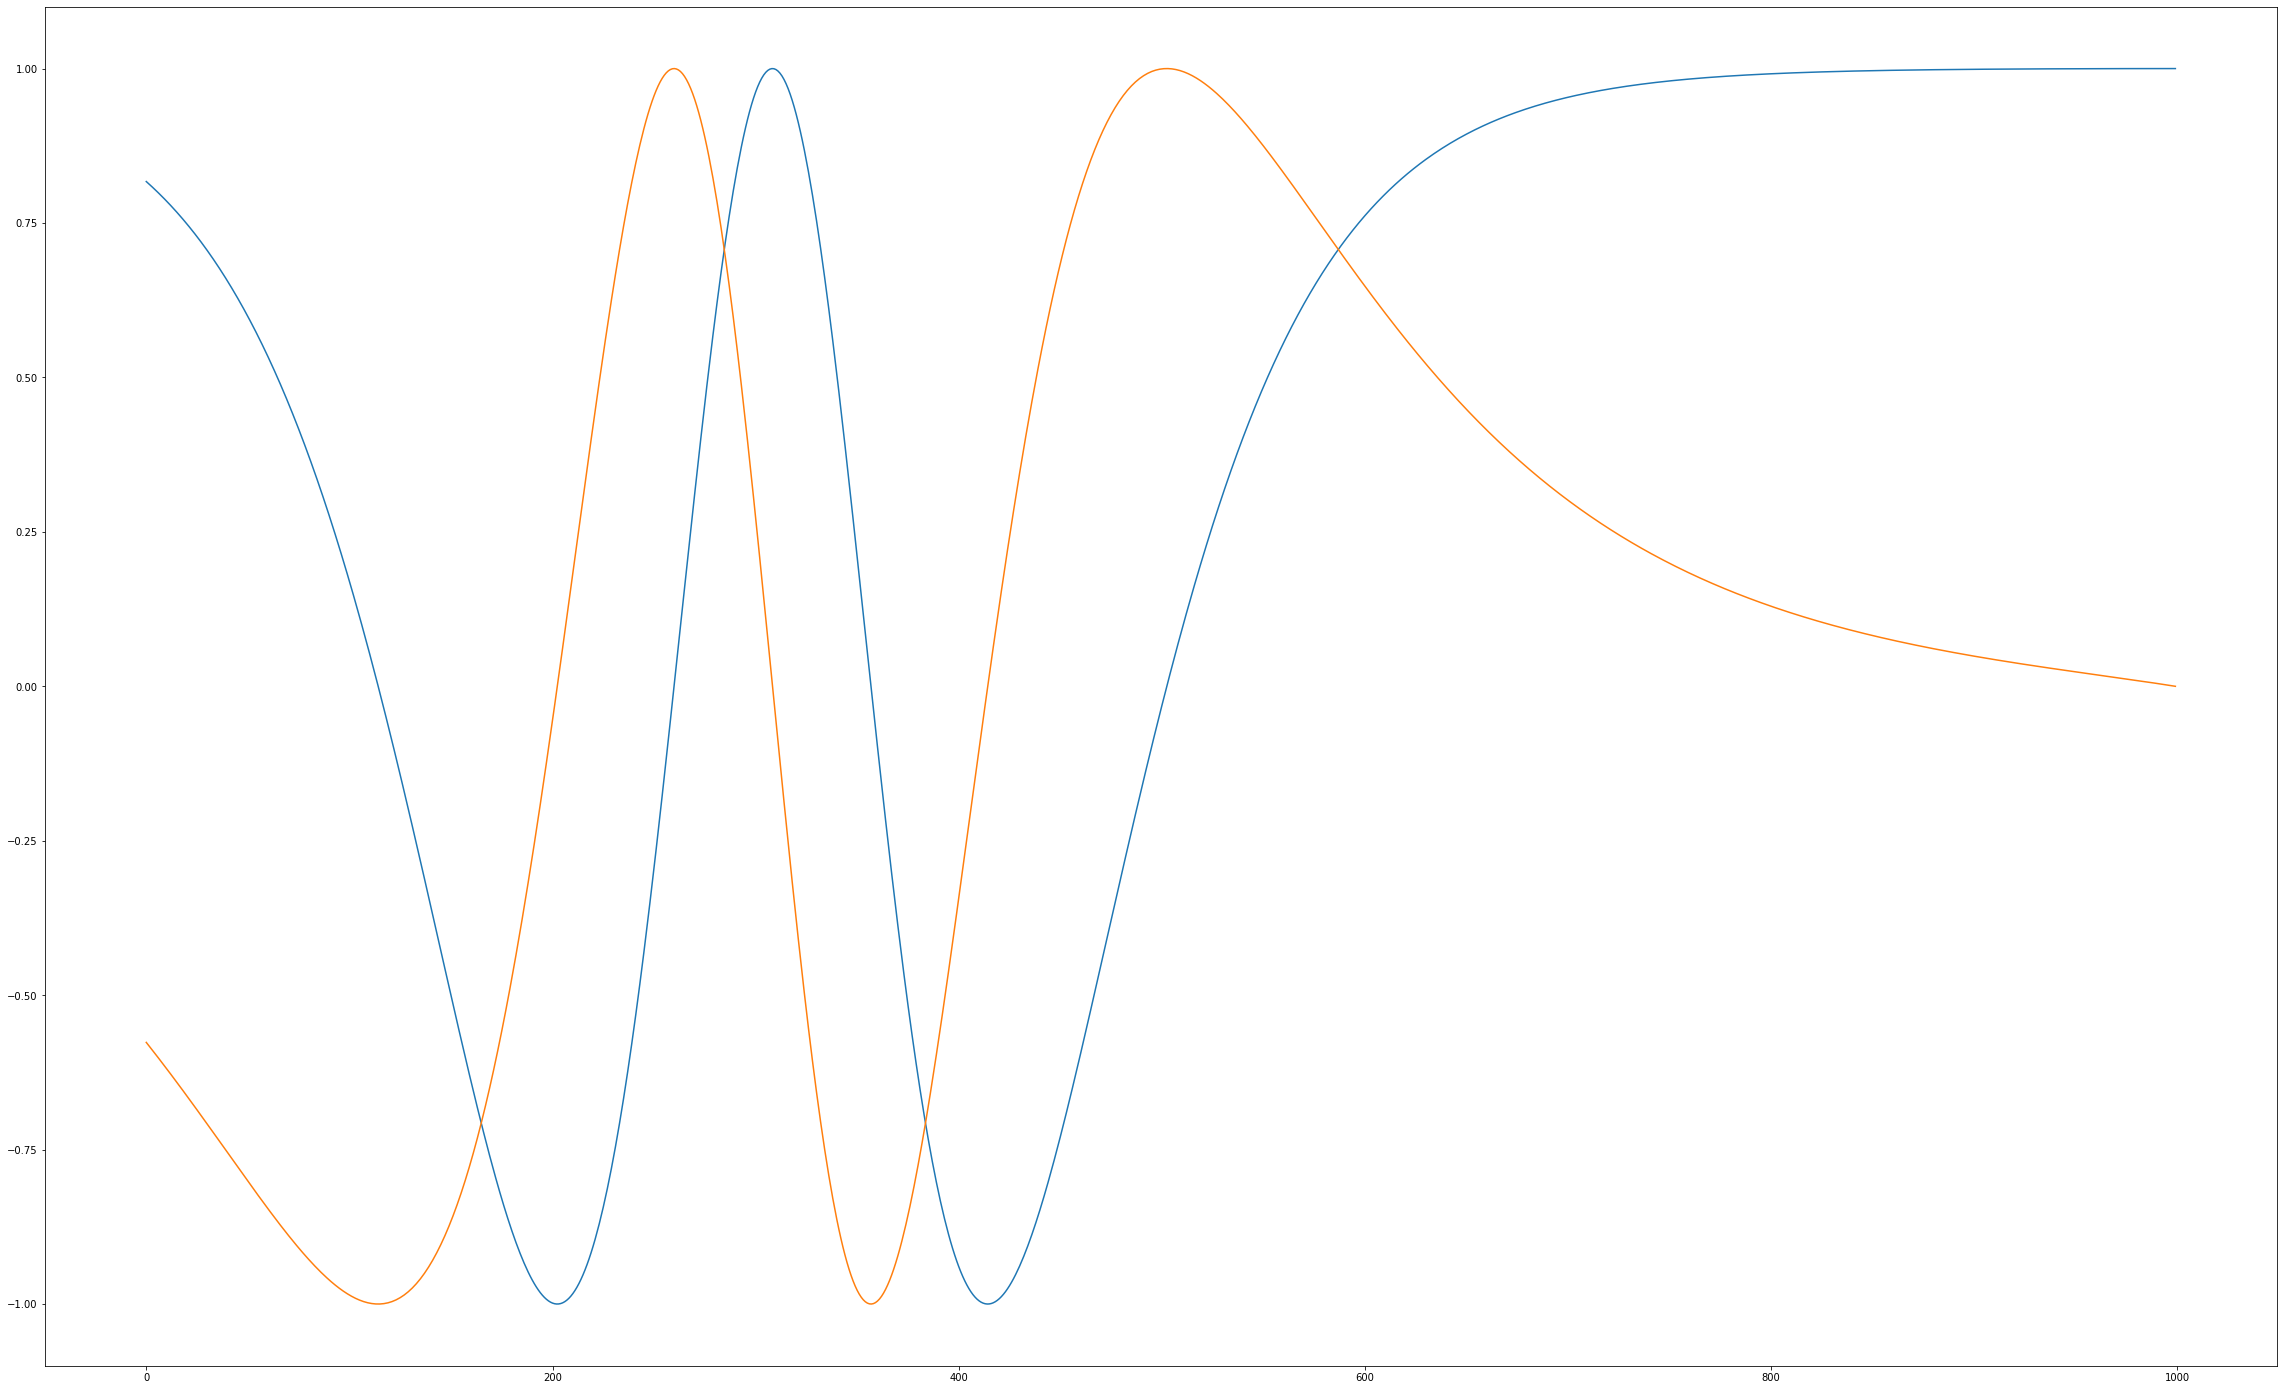

In [51]:
perc = (schwarz(0.99) * schwarz(0.99) * schwarz(0.99) * schwarz(0.99)).true_perceptual(1000)

plt.plot(perc.real[1:]); plt.plot(perc.imag[1:]); plt.show()

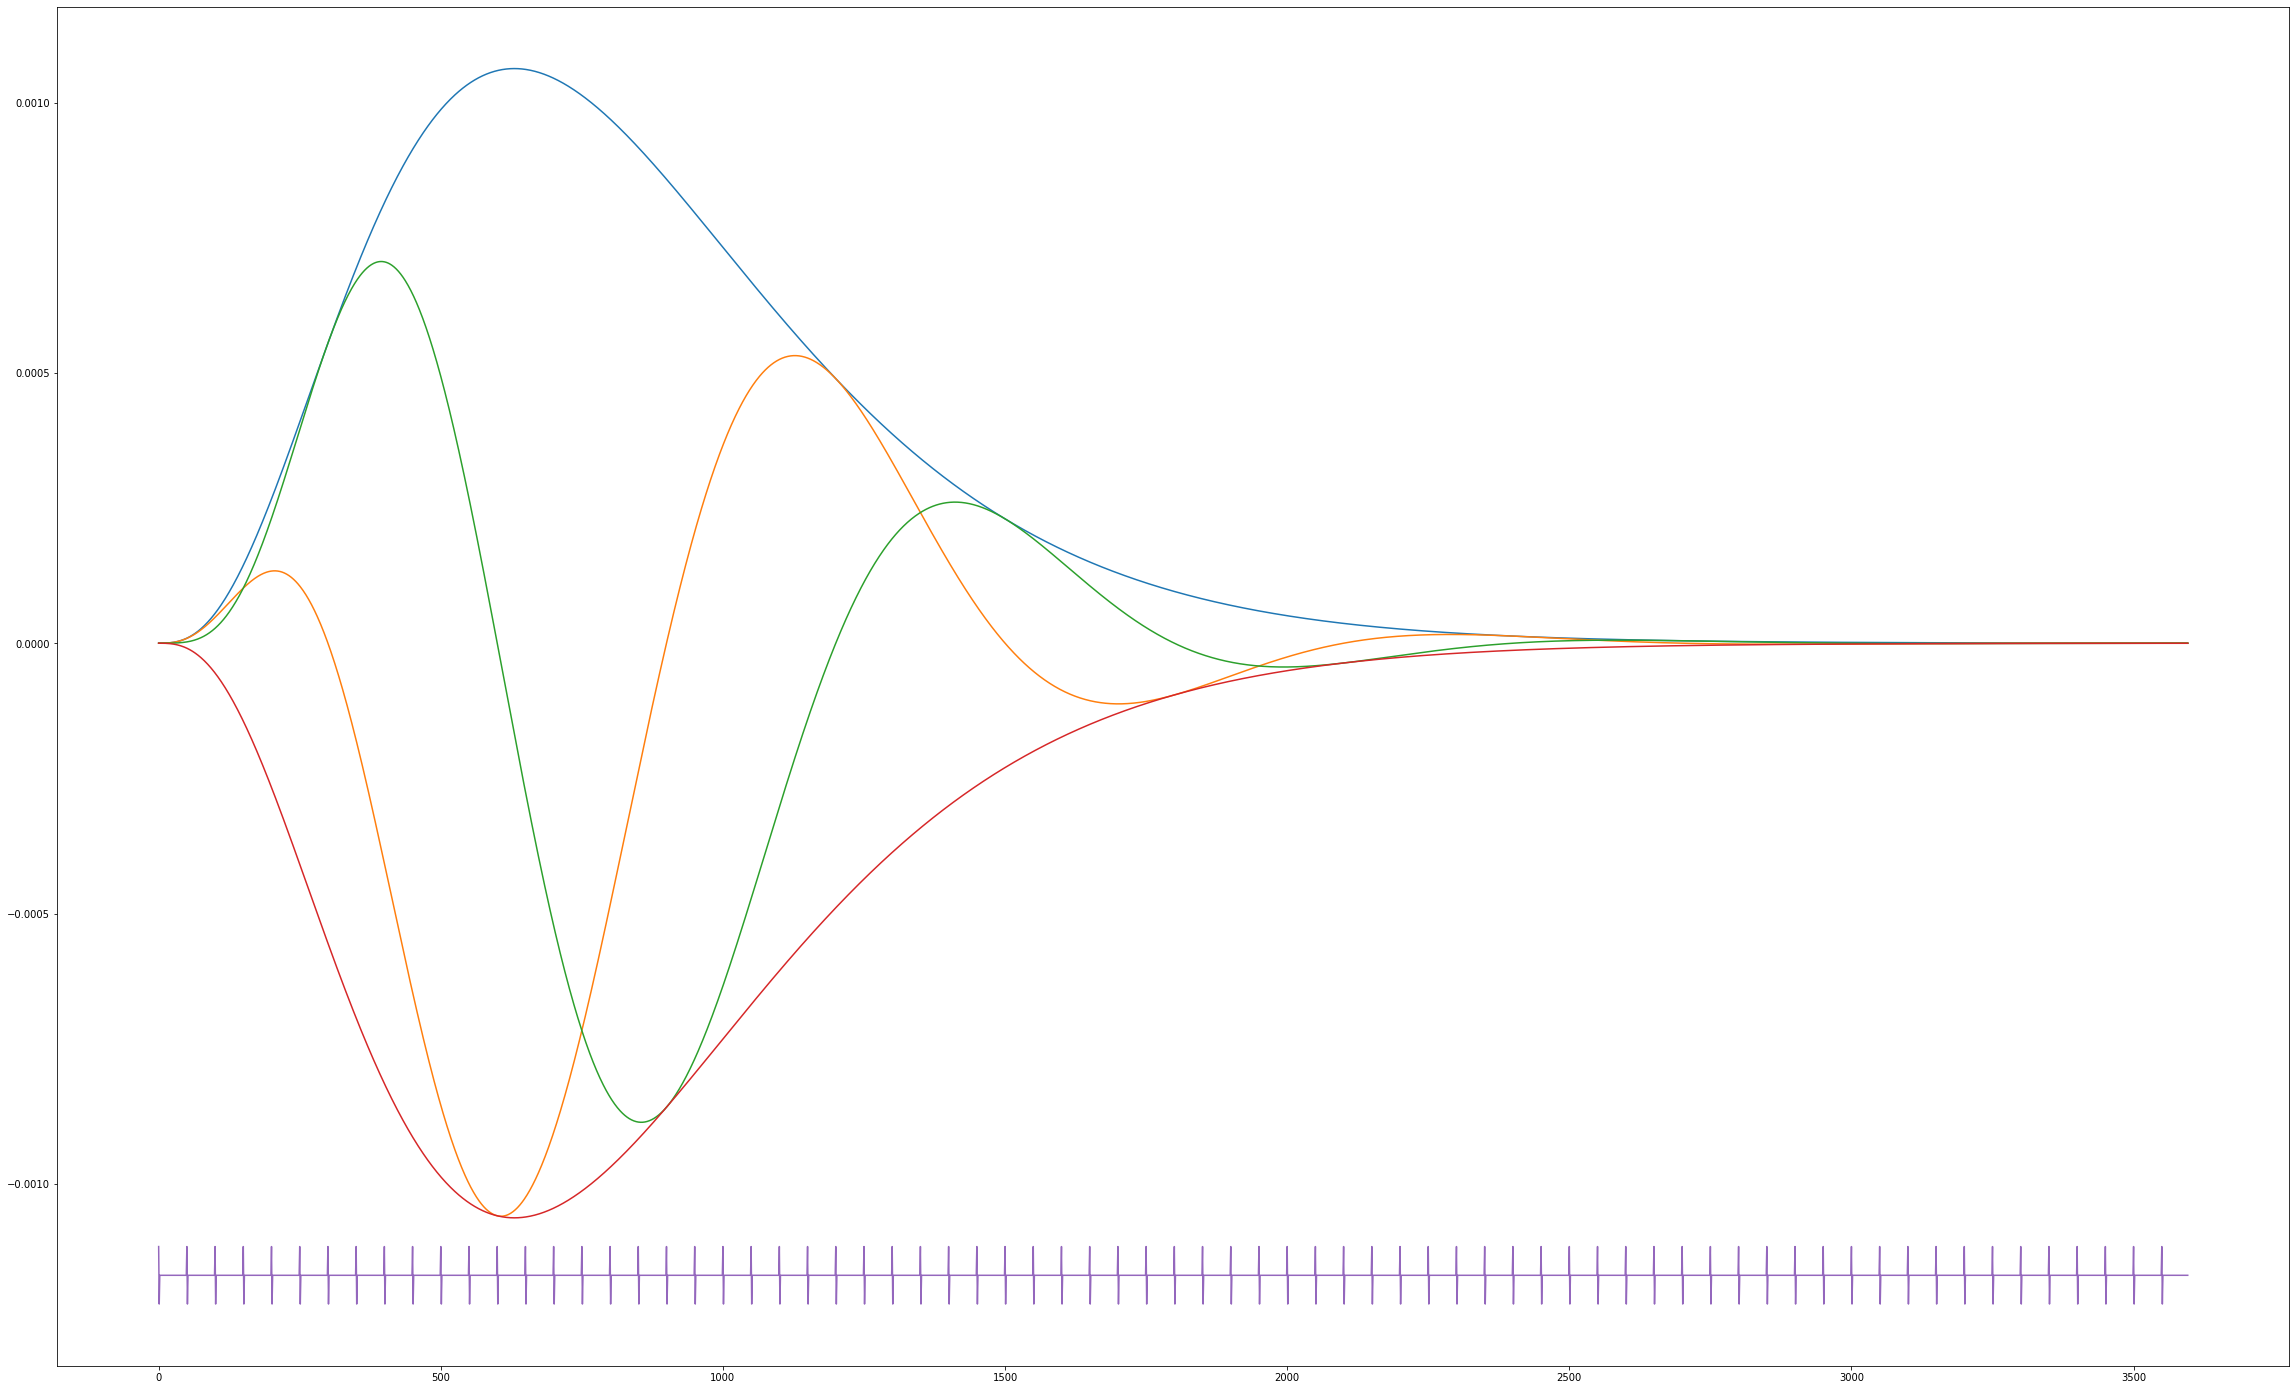

In [35]:
N = 4
k = 1
f = 40
SR = 48000
r = np.exp((np.log(1/2) - N - 1) / (k * SR / f))
pivot = int((np.log(1/2) - N - 1) / np.log(r))
M = pivot * 3
Fs = [Filter([1-r], [0,-r]) for i in range(N)]
record = np.zeros(M)
for i in range(M):
    value = int(i == 0)
    for j in range(N):
        value = Fs[j](value)
        Fs[j].tick()
    record[i] = value
    
scale = max(record)
plt.plot(record)
enveloped = record * np.array([np.exp(2j * np.pi * n / SR * f) for n in range(M)])
plt.plot(enveloped.real)
plt.plot(enveloped.imag)
plt.plot(-record)
plt.plot(np.array([scale * ((i % (SR // 960) == 0) - ((i - 1) % (SR // 960) == 0)) / 20 - scale * (1 + 1/10) for i in range(M)]))
plt.show()


In [315]:
# pivot = int((N - 1) / (1 - r) + (np.log(1/2) / np.log(r)))
pivot = int(-(N-1) / np.log(r) + (np.log(1/2) / np.log(r)))
sum(record[:pivot]), sum(record[:1 + pivot])

(0.5036807270095893, 0.5038091996578188)

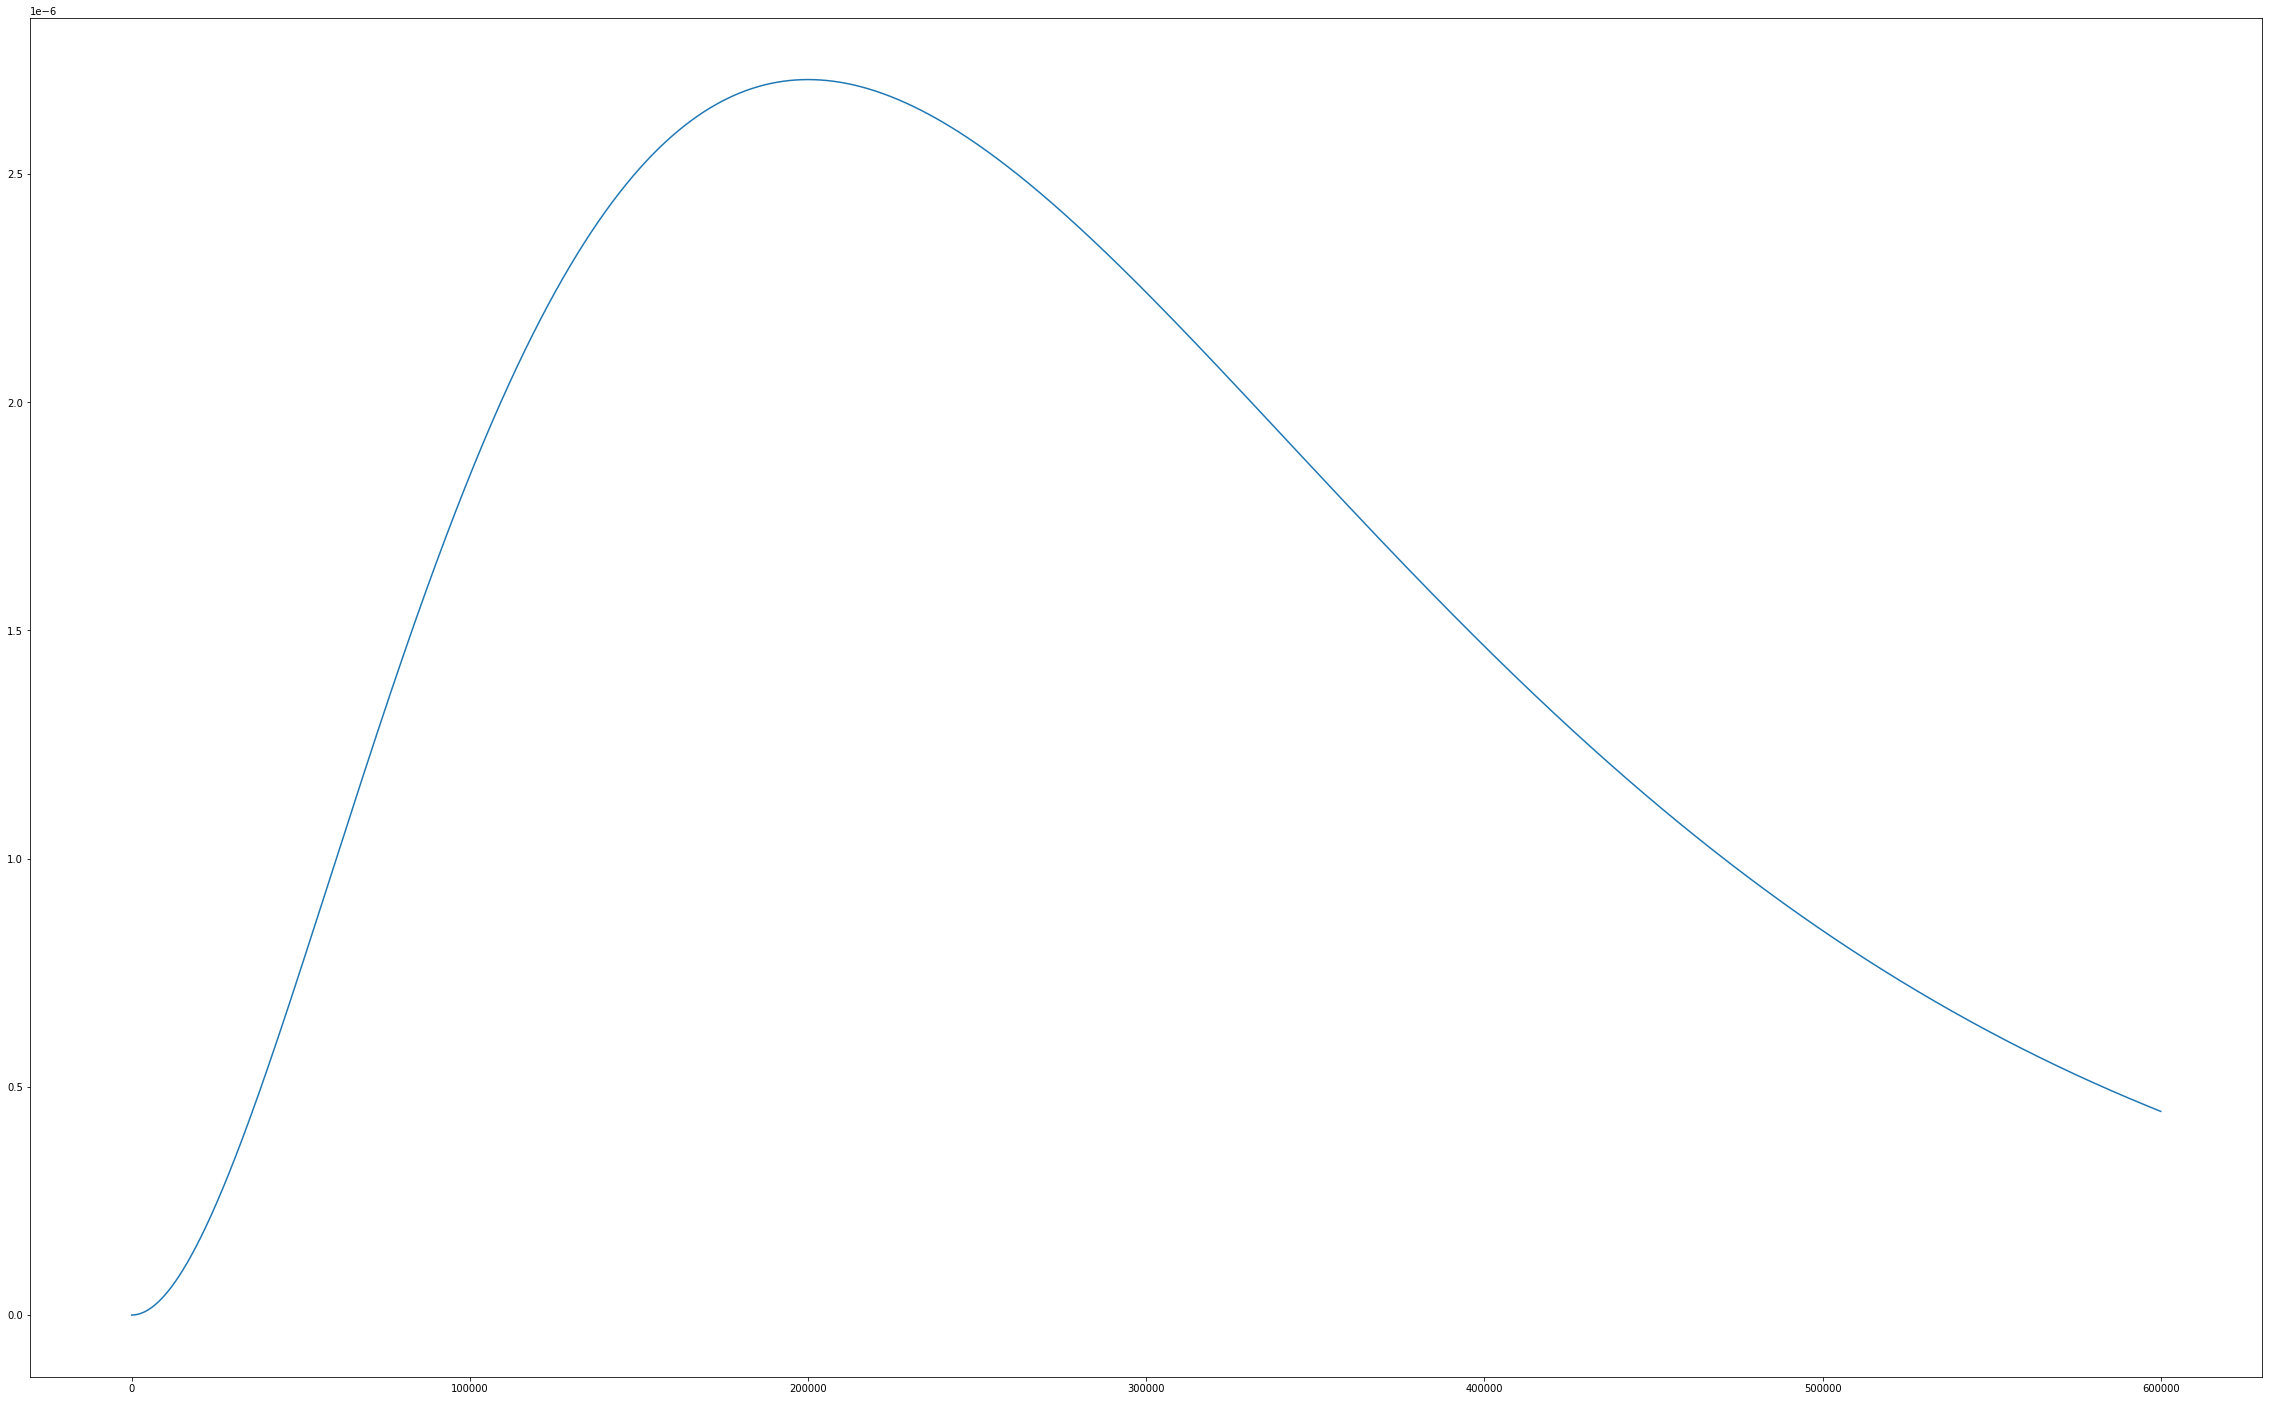

In [298]:
alpha = 0.99999
pivot = int(-2/np.log(alpha))
plt.plot(np.array([taylor(alpha, n, 3) for n in range(3 * pivot)]).real)

In [28]:
# return nth coefficient of taylor series of (1 - r)^n / (1 - r)^n
def taylor(r, n, N):
    return (1 - r) ** N * r**n * np.prod([n + i for i in range(1,N)]) / np.math.factorial(N-1) 

In [242]:
np.prod([1,2])

2

In [281]:
(np.log(1/2) / np.log(r))

6931.125226233421

In [282]:
(N - 1) / (1 - r)

90000.00000000991

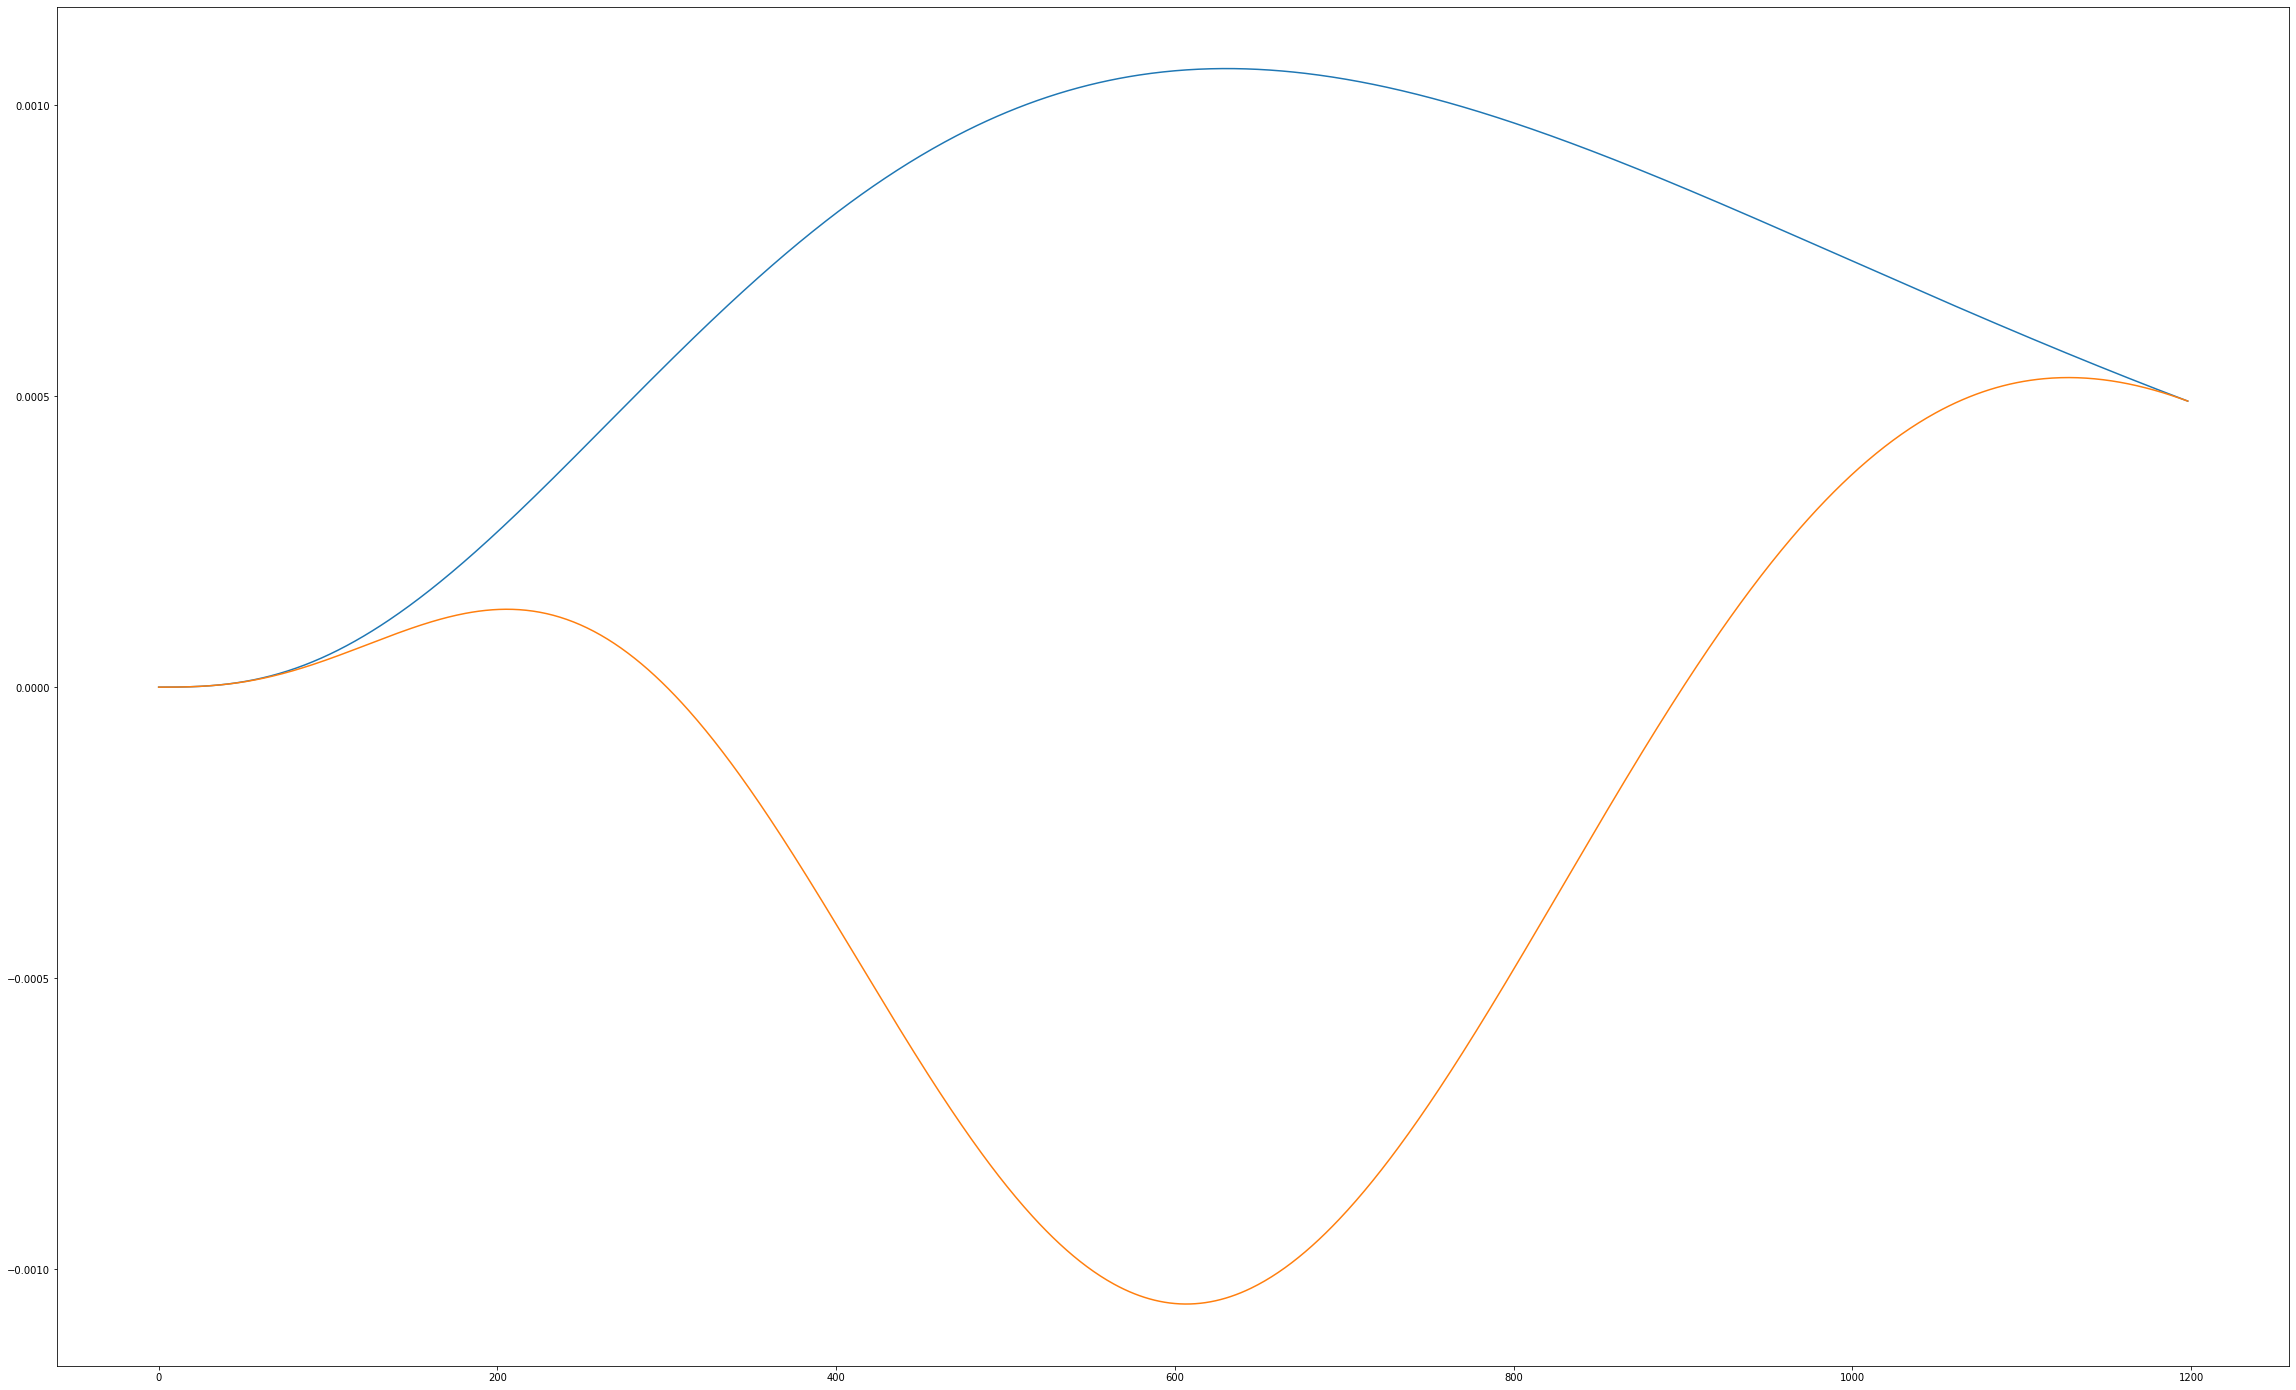

In [351]:
N = 4
k = 1
f = 40
SR = 48000
r = np.exp((np.log(1/2) - N - 1) / (k * SR / f))
pivot = int((np.log(1/2) - N - 1) / np.log(r))
profile = np.array([taylor(r, n, N) for n in range(pivot)])
plt.plot(profile)
plt.plot(profile * np.array([np.exp(2j * np.pi * n / SR * f) for n in range(pivot)]).real)
plt.show()

In [319]:
r

0.9697888374076148

Below we analyze the filter in the `slidebank` example project. It consists of an ensemble of logarithmically spaced $k^\text{th}$-order filters whose poles' radii are set such that the impulse responses take a constant number of wavelengths to come to resonance.

While we're at it, we'll also analyze what goes on in the `filterbank` example, which operates similarly and has some unexpected behavior. 

In [153]:
courses = 10 # "strings" per notes coursed,
harmonics = 1 # overtones
octaves = 8 # number of octaves
division = 12 # edo
parities = 1 # either 1 or 2
N = parities * division * octaves * courses * harmonics # lots of filters!

detune = 0.125;
frequency = 27.5; # E1
SR = 48000;

multiplicity = 1; # low-pass multiplicity
wavelengths = 10;

scale = [0 for i in range(division * octaves * harmonics)];
diatonic = [0,2,4,5,7,9,11];
poles = [0 for i in range(division * octaves * courses * harmonics * parities)]
# poles = [0.999 for i in range(division * octaves * courses * harmonics * parities)]

def transpose(reverse = False):
    for i in range(division * octaves):
        for j in range(courses):
            for k in range(harmonics):
                for l in range(parities):
                    midi = (scale[i] + detune * pow((2 * (j + 0.5) / courses - 1), 1)) / division;
                    partial = frequency * pow(2, midi) * (k + 1) * pow(-1, l);
                    
                    poles[parities * (harmonics * (courses * i + j) + k) + l] = \
                        np.exp( \
                            2j * np.pi * (-1 if reverse else 1) * partial / SR + \
                            (np.log(0.5) - multiplicity - 1) / (wavelengths * SR / abs(partial)) \
                              );
#                     poles[parities * (harmonics * (courses * i + j) + k) + l] = np.exp(2j * np.pi * (-1 if reverse else 1) * partial / SR) * 0.99999
                    
def defaultize():
    for i in range(division * octaves):
        scale[i] = i;

defaultize()
transpose()



In [154]:
A = [np.array([taylor(poles[j], i, multiplicity) for i in range(SR)]) for j in range(N)]

In [155]:
B = sum(A)

In [57]:
from numpy.fft import fft

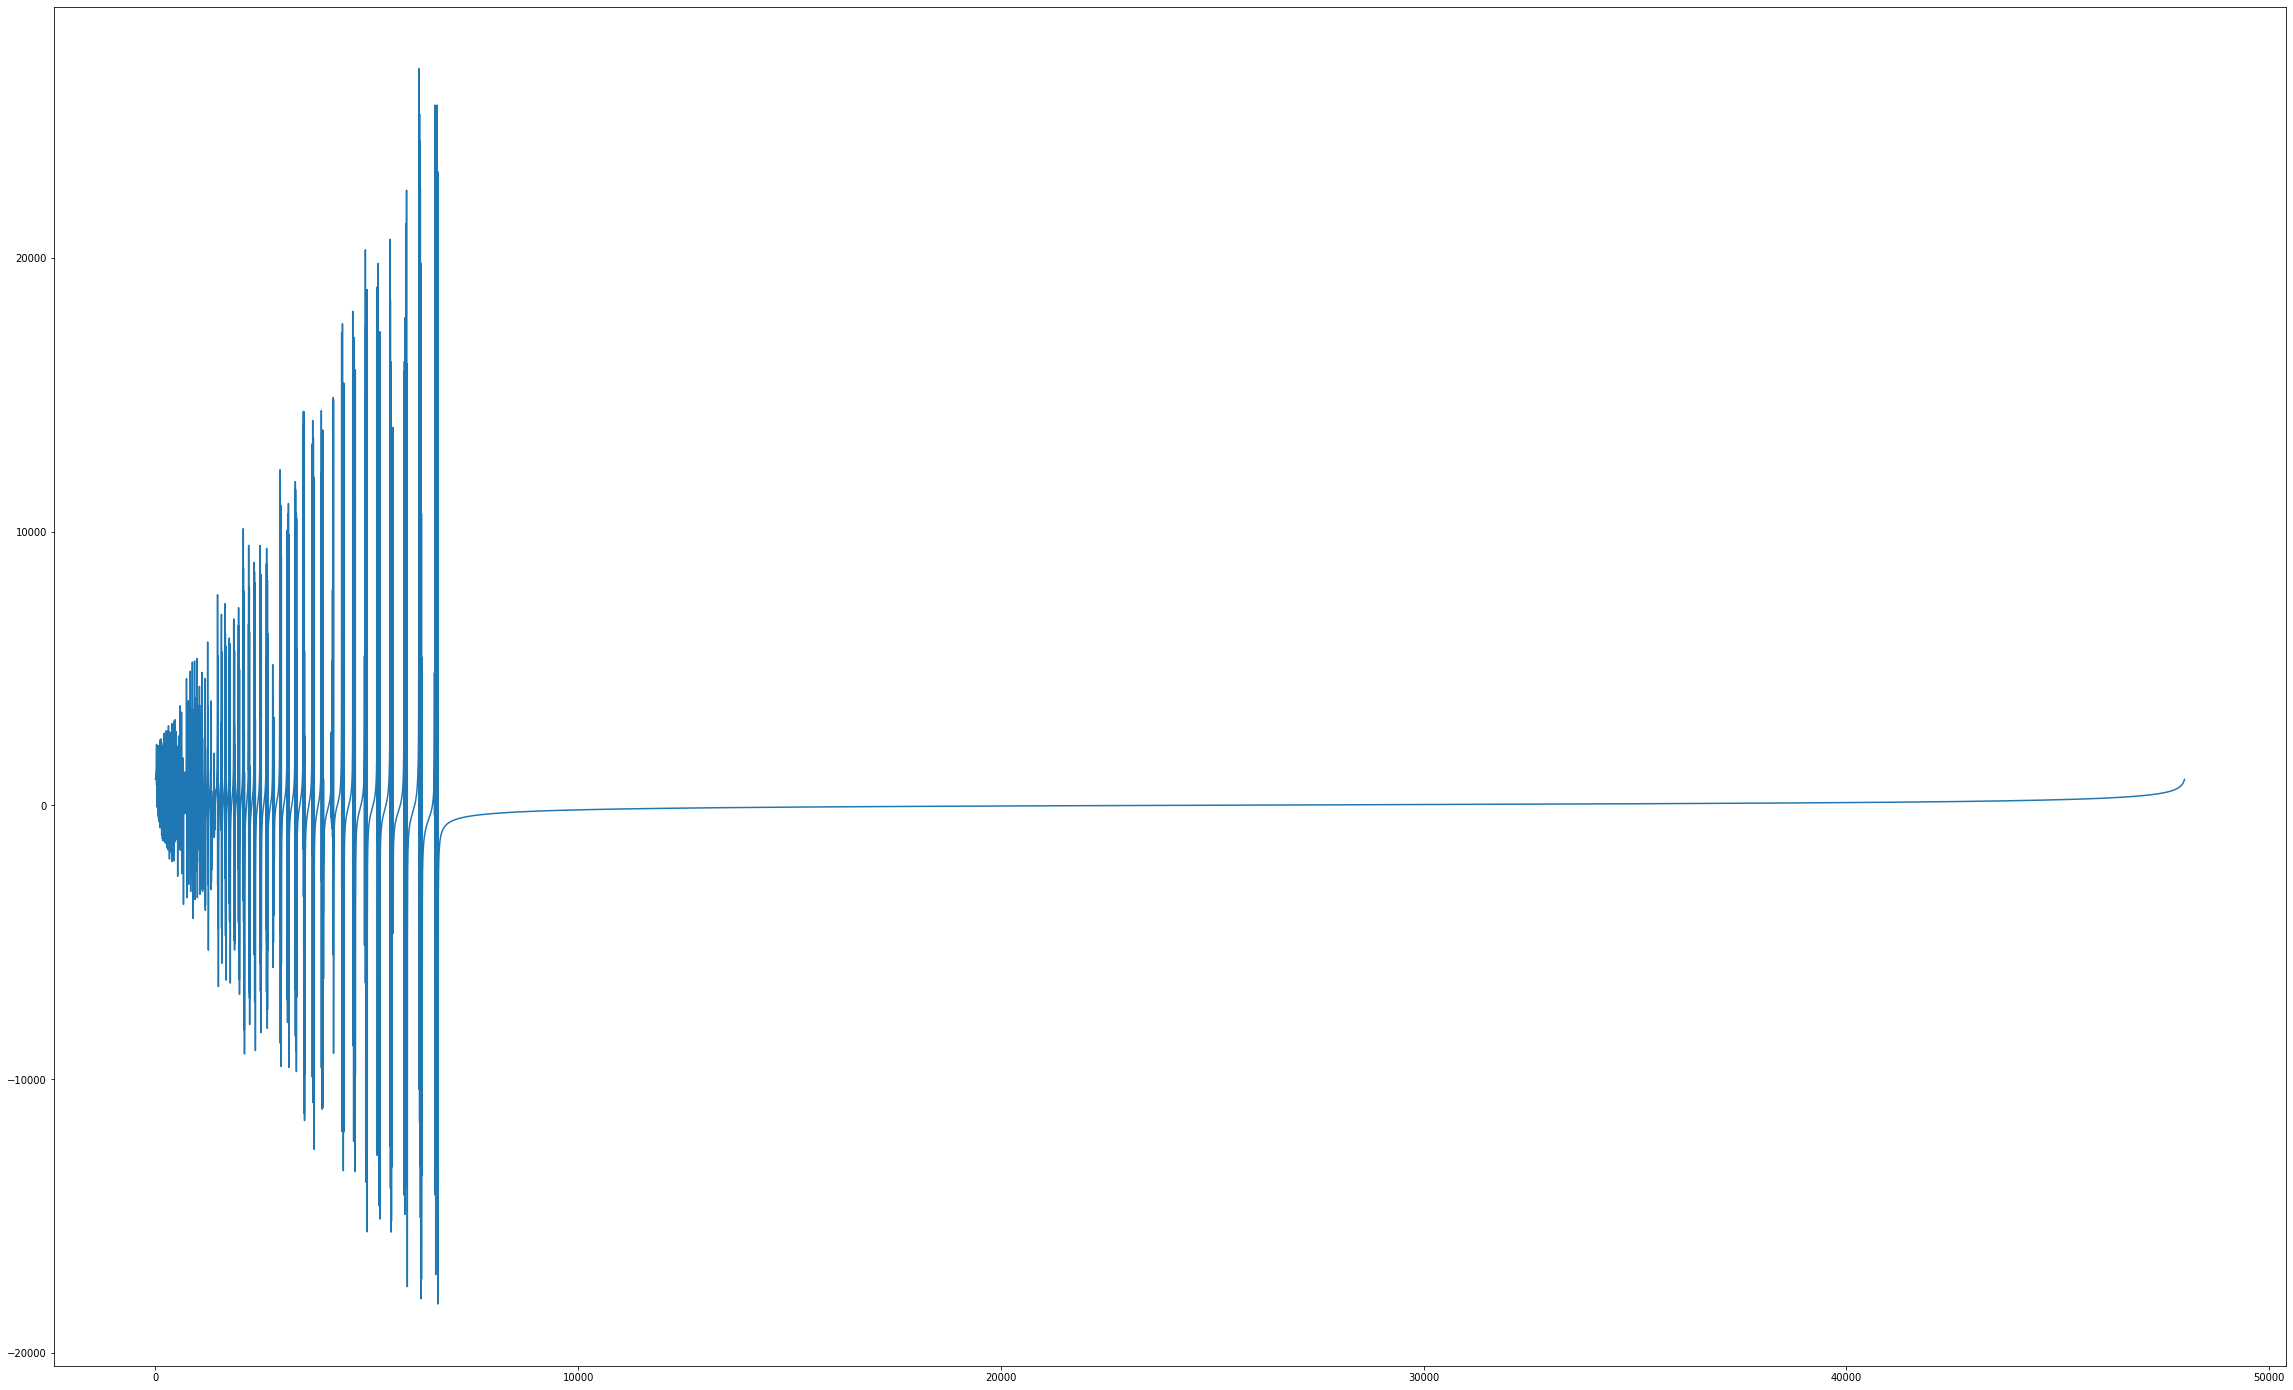

In [161]:
plt.plot(fft(B).real)
# for a in A:
#     plt.plot(a[:100])
# plt.show()

In [99]:
# computes M samples of impulse response of k-th order single-pole filter
def impulse(r, order, M):
    Fs = [Filter([1-r], [0,-r]) for i in range(order)]
    record = np.zeros(M, dtype = "complex")
    for i in range(M):
        value = int(i == 0)
        for j in range(order):
            value = Fs[j](value)
            Fs[j].tick()
        record[i] = value
    return record

In [101]:
C = [impulse(poles[j], multiplicity, SR) for j in range(N)]

In [146]:
impulse(poles[0], multiplicity, SR)

array([ 7.10802405e-13-1.48774540e-13j,  3.55311007e-12-7.30343307e-13j,
        1.06564811e-11-2.15049233e-12j, ...,
       -2.18884374e-16+4.82866284e-17j, -2.18855955e-16+4.74548461e-17j,
       -2.18824571e-16+4.66239338e-17j])

In [122]:
C

[array([ 3.19149227e-13-5.32878835e-13j,  1.60471144e-12-2.65761336e-12j,
         4.84094656e-12-7.95240880e-12j, ...,
        -7.04059853e-04+1.20488869e-03j, -7.08179993e-04+1.20198565e-03j,
        -7.12288422e-04+1.19906867e-03j]),
 array([ 3.19149227e-13+5.32878835e-13j,  1.60471144e-12+2.65761336e-12j,
         4.84094656e-12+7.95240880e-12j, ...,
        -7.04059853e-04-1.20488869e-03j, -7.08179993e-04-1.20198565e-03j,
        -7.12288422e-04-1.19906867e-03j]),
 array([4.26369193e-13-7.11039096e-13j, 2.14451779e-12-3.54559849e-12j,
        6.47144339e-12-1.06078715e-11j, ...,
        6.12000943e-04-1.19207257e-04j, 6.12253376e-04-1.16834615e-04j,
        6.12496679e-04-1.14461794e-04j]),
 array([4.26369193e-13+7.11039096e-13j, 2.14451779e-12+3.54559849e-12j,
        6.47144339e-12+1.06078715e-11j, ...,
        6.12000943e-04+1.19207257e-04j, 6.12253376e-04+1.16834615e-04j,
        6.12496679e-04+1.14461794e-04j]),
 array([ 5.69637918e-13-9.48742897e-13j,  2.86609972e-12-4.73013

In [130]:
B

array([216.,   0.,   0., ...,   0.,   0.,   0.])

In [131]:
a[0]

1.0

In [132]:
a[1]

0.0

In [133]:
A

[array([1., 0., 0., ..., 0., 0., 0.]),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([1., 0., 0., ..., 